## Estimate the amount of time that ATBs are full 

This notebook evaluates ATBs in our study.  It identifies the top importeres (by number of transfers) and top exporters (also by number of transfers).  It also matches the names from the DOE with MMSI values in [ATB_MMSI](https://docs.google.com/spreadsheets/d/1dlT0JydkFG43LorqgtHle5IN6caRYjf_3qLrUYqANDY/edit) and creates a dataframe with information the compares DOE transfer quatities to cargo capacity by vessel.  This notebook is a compliment to [ATB_FullEmptyRatio_AISplot.ipynb](https://github.com/MIDOSS/analysis-rachael/blob/main/notebooks/monte_carlo/ATB_FullEmptyRatio_AISplot.ipynb) in which I plot up AIS ship trackes for the top 3 importers and top 3 exporters (total of 5 vessels) to address whether vessel operations extend up to CAD or if they are represented entirely in DOE database.  Comparing import vs. export transfers between the trans-boundary and non-transboundary vessels ought to give a more clear sense of representative values to use.  Lastly, I collate information in `Top_six_ATBs_by_DOEtransfers.xlsx` to give an overview of import vs. export transfer behaviors for each of these five vessels and the WA marine terminals that they are documented as servicing in the DOE database. 

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
 ```
or, to activate this environment, use
```
 conda activate monte_carlo
 ```
To deactivate an active environment, use
```
 conda deactivate
 ```

In [1]:
import pandas 
import numpy 
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import datetime

# import functions for querying DOE and monte-carlo dataframes
from monte_carlo_utils import get_DOE_df, get_DOE_atb

In [2]:
# Dept. of Ecology data files
DOE_dir  = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
DOE_2018_xlsx = DOE_dir/'MuellerTrans4-30-20.xlsx'

# ATB spreadsheet
atb_dir = Path('/Users/rmueller/Projects/MIDOSS/AIS/origin_destination_analysis')
atb_xlsx = atb_dir/'ATB_MMSIs.xlsx'
atb_out_xlsx = atb_dir/'ATB_'

# Facility names and lat/lon information file
facilities_xlsx = Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
    'Oil_Transfer_Facilities.xlsx'
)

# Load Oil Attribution file 
oil_attribution_file = '/Users/rmueller/Data/MIDOSS/marine_transport_data/oil_attribution.yaml'

with open(oil_attribution_file) as file:
        oil_attrs = yaml.load(file, Loader=yaml.Loader)

In [3]:
# convert cargo capacity to gallons since DOE transfers are in gallons
bbl2gal = 42

In [4]:
atb_df={}
atb_df['MMSI'] = pandas.read_excel(
    atb_xlsx,
    sheet_name='DOE ATBs', 
    usecols="A,B"
    )
atb_df['Capacity'] = pandas.read_excel(
    atb_xlsx,
    sheet_name=0,
    nrows=21,
    usecols="A,F,I,J"
)

In [5]:
atb_df['Capacity']

,MMSI,Vessel length,Fuel Capacity,Cargo Capacity
0,303668000.0,NaN,NaN,"178,000 bbl"
1,316001221.0,NaN,NaN,NaN
2,316001223.0,41.45 m,NaN,NaN
3,316006101.0,NaN,NaN,NaN
4,316038089.0,NaN,NaN,NaN
5,338134000.0,136 ft,"150,000 gallons","185,000 barrels"
6,338616000.0,125.8 ft,"144,000 gallons","150,000 barrels"
7,366341000.0,NaN,NaN,"178,000 bbl"
8,366866930.0,NaN,NaN,NaN
9,366904000.0,NaN,NaN,"178,000 bbl"


In [6]:
atb_df['MMSI']['MMSI'][2,14,16,17]=numpy.NaN

In [7]:
atb_df['MMSI'] = atb_df['MMSI'].drop(index=13)
atb_df['MMSI'] = pandas.merge(
    left = atb_df['MMSI'],
    right = atb_df['Capacity'],
    how='left',
    on = 'MMSI'
)
atb_df['MMSI']

,DELIVERER,MMSI,Vessel length,Fuel Capacity,Cargo Capacity
0,ATB BARGE 550-2,369580000,NaN,NaN,"155,000 bbls"
1,ATB BARGE 550-3,369703000,NaN,NaN,"155,000 bbls"
2,ITB ISLAND TRADER,NaN,NaN,NaN,NaN
3,ATB BARGE KIRBY 185-01,338134000,136 ft,"150,000 gallons","185,000 barrels"
4,ATB BARGE 650-7,366341000,NaN,NaN,"178,000 bbl"
5,ATB BARGE ONEDREAM,368006870,111.3 ft,"101,383 gallons",NaN
6,ATB BARGE 650-10,366904000,NaN,NaN,"178,000 bbl"
7,ATB BARGE DBL 185,338616000,125.8 ft,"144,000 gallons","150,000 barrels"
8,ATB BARGE ALL ABOARD FOR A CURE,368013040,111.3 ft,"101,383 gallons",NaN
9,ATB BARGE 650-2,303668000,NaN,NaN,"178,000 bbl"


In [8]:
atb_df['MMSI']['Cargo Capacity'][0,1] = 155000
atb_df['MMSI']['Cargo Capacity'][3] = 185000
atb_df['MMSI']['Cargo Capacity'][4,6,9] = 178000
atb_df['MMSI']['Cargo Capacity'][7] = 150000
atb_df['MMSI']['Cargo Capacity'][11] = 80000
atb_df['MMSI']['Cargo Capacity'] = bbl2gal * atb_df['MMSI']['Cargo Capacity']
atb_df['MMSI'] = atb_df['MMSI'].drop(columns=["Vessel length",'Fuel Capacity','MMSI'])

In [9]:
[imports, exports]=get_DOE_atb(DOE_2018_xlsx, facilities_xlsx, transfer_type = 'cargo', facilities='selected')

In [10]:
len(imports)

210

In [11]:
len(exports)

467

In [12]:
exports.head()

,AntID,StartDateTime,Deliverer,Receiver,Product,TransferQtyInGallon,TransferType,DelivererTypeDescription,ReceiverTypeDescription,ImportRegion,ExportRegion
7,173493,2018-01-02 01:00:00,Shell Puget Sound Refinery,ATB BARGE KIRBY 185-01,BUNKER OIL/HFO,3150000.0,Cargo,Facility,TANK BARGE,not attributed,Anacortes
8,173493,2018-01-02 01:00:00,Shell Puget Sound Refinery,ATB BARGE KIRBY 185-01,DIESEL/MARINE GAS OIL,3360000.0,Cargo,Facility,TANK BARGE,not attributed,Anacortes
21,173546,2018-01-01 21:00:00,Phillips 66 Ferndale Refinery,ATB BARGE 550-2,GASOLINE,3906000.0,Cargo,Facility,TANK BARGE,not attributed,Whatcom County
22,173547,2018-01-02 12:00:00,Phillips 66 Ferndale Refinery,ATB BARGE FIGHT FANCONI ANEMIA,GASOLINE,1890000.0,Cargo,Facility,TANK BARGE,not attributed,Whatcom County
23,173547,2018-01-02 12:00:00,Phillips 66 Ferndale Refinery,ATB BARGE FIGHT FANCONI ANEMIA,DIESEL/MARINE GAS OIL,1470000.0,Cargo,Facility,TANK BARGE,not attributed,Whatcom County


In [13]:
# imports
import_df = {}
# define way to group dataframe
aggregation_functions = {'AntID': 'first', 'Deliverer': 'first', 'TransferQtyInGallon': 'sum'}
imports_sm = imports[['AntID','Deliverer','TransferQtyInGallon']]
# first group by transfer ID
imports_sm_AndID = imports_sm.groupby(imports['AntID']).aggregate(aggregation_functions)
# now group by deliverer
import_df =  imports_sm_AndID[['Deliverer','TransferQtyInGallon']].groupby(
    'Deliverer').count().rename(columns={'TransferQtyInGallon':'Count'})
import_df.head()
import_df = pandas.merge(
    left = import_df,
    right = imports_sm_AndID[['Deliverer','TransferQtyInGallon']].groupby('Deliverer').sum(),
    how='left',
    on = 'Deliverer'
)
import_df['AverageQty'] = import_df['TransferQtyInGallon']/import_df['Count']
len(import_df)

13

In [14]:
imports_sm_AndID.head(2)

,AntID,Deliverer,TransferQtyInGallon
AntID,,,
173491,173491,ITB ISLAND TRADER,966000.0
173492,173492,ITB ISLAND TRADER,1680000.0


In [15]:
import_df.sort_values(by='Count', ascending=False)

,Count,TransferQtyInGallon,AverageQty
Deliverer,,,
ATB BARGE ALL ABOARD FOR A CURE,40,60984000.0,1.524600e+06
ATB BARGE DBL 185,29,23860410.0,8.227728e+05
ITB ISLAND TRADER,27,32734800.0,1.212400e+06
ATB BARGE ONEDREAM,23,58044000.0,2.523652e+06
ATB BARGE 550-2,20,28308000.0,1.415400e+06
ATB BARGE 650-10,14,28857150.0,2.061225e+06
ATB BARGE FIGHT FANCONI ANEMIA,11,20384000.0,1.853091e+06
ATB TUG ISLAND MONARCH,7,9487800.0,1.355400e+06
ATB BARGE KIRBY 185-01,5,20137110.0,4.027422e+06


In [16]:
# exports
export_df = {}
aggregation_functions = {'AntID': 'first', 'Receiver': 'first', 'TransferQtyInGallon': 'sum'}
exports_sm = exports[['AntID','Receiver','TransferQtyInGallon']]
exports_sm_AndID = exports_sm.groupby(exports['AntID']).aggregate(aggregation_functions)
export_df =  exports_sm_AndID[['Receiver','TransferQtyInGallon']].groupby(
    'Receiver').count().rename(columns={'TransferQtyInGallon':'Count'})
export_df.head()
export_df = pandas.merge(
    left = export_df,
    right = exports_sm_AndID[['Receiver','TransferQtyInGallon']].groupby('Receiver').sum(),
    how='left',
    on = 'Receiver'
)
export_df['AverageQty'] = export_df['TransferQtyInGallon']/export_df['Count']
len(export_df)

17

In [17]:
export_df.sort_values(by='Count', ascending=False)

,Count,TransferQtyInGallon,AverageQty
Receiver,,,
ATB BARGE DBL 185,43,324366000.0,7.543395e+06
ATB BARGE 550-2,42,206270400.0,4.911200e+06
ATB BARGE ONEDREAM,38,109195800.0,2.873574e+06
ATB BARGE FIGHT FANCONI ANEMIA,33,80010000.0,2.424545e+06
ATB BARGE 650-10,32,120372000.0,3.761625e+06
ATB BARGE ZIDELL MARINE 277,30,53088000.0,1.769600e+06
ATB BARGE ALL ABOARD FOR A CURE,30,63378000.0,2.112600e+06
ATB BARGE KIRBY 185-01,11,44310000.0,4.028182e+06
ITB SUPPLIER,9,5271864.0,5.857627e+05


## Create a list consisting of the top three importers and the top three exporters and evaluate where imports/exports are going to/from

In [18]:
top_imports = import_df.iloc[import_df['Count'].argsort()[-3:]].index.tolist()
top_exports = export_df.iloc[export_df['Count'].argsort()[-3:]].index.tolist()
top_dawgs = top_imports + list(set(top_exports) - set(top_imports))
print(top_dawgs)

['ITB ISLAND TRADER', 'ATB BARGE DBL 185', 'ATB BARGE ALL ABOARD FOR A CURE', 'ATB BARGE ONEDREAM', 'ATB BARGE 550-2']


In [19]:
for dawg in top_dawgs:
    print(dawg)
    print(imports.loc[
            imports.Deliverer == dawg,
            ['Receiver','Product']
        ].groupby('Receiver').count()
    )
    print('')

ITB ISLAND TRADER
                                                Product
Receiver                                               
Kinder Morgan Liquids Terminal - Harbor Island        3
SeaPort Sound Terminal                               14
Shell Puget Sound Refinery                           10

ATB BARGE DBL 185
                                   Product
Receiver                                  
BP Cherry Point Refinery                26
NAVSUP Manchester                        2
Shell Puget Sound Refinery               1
TLP Management Services LLC (TMS)        3

ATB BARGE ALL ABOARD FOR A CURE
                                                Product
Receiver                                               
Kinder Morgan Liquids Terminal - Harbor Island       25
Phillips 66 Ferndale Refinery                         2
SeaPort Sound Terminal                               14

ATB BARGE ONEDREAM
                                   Product
Receiver                                  
SeaPor

In [20]:
for dawg in top_dawgs:
    print(dawg)
    print(exports.loc[
            exports.Receiver == dawg,
            ['Deliverer','Product']
        ].groupby('Deliverer').count()
    )
    print('')

ITB ISLAND TRADER
Empty DataFrame
Columns: [Product]
Index: []

ATB BARGE DBL 185
                          Product
Deliverer                        
BP Cherry Point Refinery       94

ATB BARGE ALL ABOARD FOR A CURE
                               Product
Deliverer                             
BP Cherry Point Refinery             2
Phillips 66 Ferndale Refinery       36
Shell Puget Sound Refinery           2

ATB BARGE ONEDREAM
                            Product
Deliverer                          
BP Cherry Point Refinery         47
Shell Puget Sound Refinery        7

ATB BARGE 550-2
                               Product
Deliverer                             
Phillips 66 Ferndale Refinery       79



### Investigate dates for ATB BARGE DBL 185 exports from Cherry Point

In [21]:
exports.loc[
    (exports.Receiver == 'ATB BARGE DBL 185') &
    (exports.Deliverer == 'BP Cherry Point Refinery'),
    ['StartDateTime']
]

,StartDateTime
498,2018-01-18 01:00:00
499,2018-01-18 01:00:00
866,2018-01-26 20:00:00
867,2018-01-26 20:00:00
1304,2018-02-10 12:00:00
...,...
13782,2018-12-04 13:00:00
13817,2018-12-11 13:00:00
13818,2018-12-11 13:00:00
13819,2018-12-11 13:00:00


In [22]:
# Plot up shapefile of december movement for ATB BARGE DBL 185 compare to ATB BARGE ONEDREAM

In [23]:
for dawg in top_dawgs:
    print(dawg)
    print(imports.loc[
            imports.Deliverer == dawg,
            ['Receiver']
        ].groupby('Receiver').count().index.tolist()
    )

ITB ISLAND TRADER
['Kinder Morgan Liquids Terminal - Harbor Island', 'SeaPort Sound Terminal', 'Shell Puget Sound Refinery']
ATB BARGE DBL 185
['BP Cherry Point Refinery', 'NAVSUP Manchester', 'Shell Puget Sound Refinery', 'TLP Management Services LLC (TMS)']
ATB BARGE ALL ABOARD FOR A CURE
['Kinder Morgan Liquids Terminal - Harbor Island', 'Phillips 66 Ferndale Refinery', 'SeaPort Sound Terminal']
ATB BARGE ONEDREAM
['SeaPort Sound Terminal', 'Shell Puget Sound Refinery', 'TLP Management Services LLC (TMS)', 'U.S. Oil & Refining']
ATB BARGE 550-2
['Kinder Morgan Liquids Terminal - Harbor Island', 'Phillips 66 Ferndale Refinery', 'SeaPort Sound Terminal', 'U.S. Oil & Refining']


In [24]:
for dawg in top_dawgs:
    print(dawg)
    print(exports.loc[
            exports.Receiver == dawg,
            ['Deliverer']
        ].groupby('Deliverer').count().index.tolist()
    )

ITB ISLAND TRADER
[]
ATB BARGE DBL 185
['BP Cherry Point Refinery']
ATB BARGE ALL ABOARD FOR A CURE
['BP Cherry Point Refinery', 'Phillips 66 Ferndale Refinery', 'Shell Puget Sound Refinery']
ATB BARGE ONEDREAM
['BP Cherry Point Refinery', 'Shell Puget Sound Refinery']
ATB BARGE 550-2
['Phillips 66 Ferndale Refinery']


### Create historgrams for "top dawg" transfers

In [55]:
bin_values = numpy.arange(0,5e7,5e7/20)

ITB ISLAND TRADER


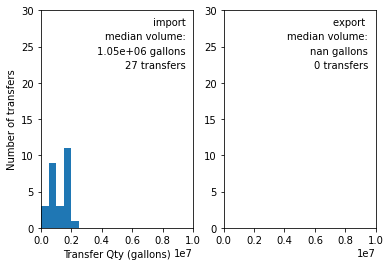

ATB BARGE DBL 185


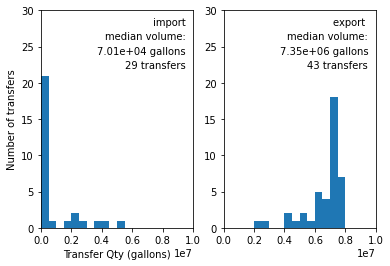

ATB BARGE ALL ABOARD FOR A CURE


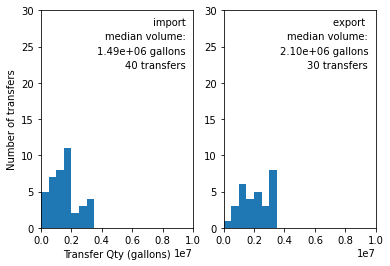

ATB BARGE ONEDREAM


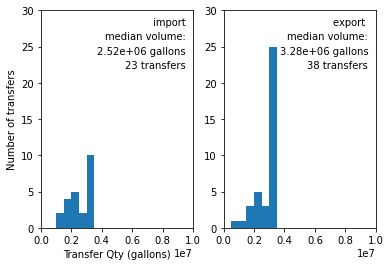

ATB BARGE 550-2


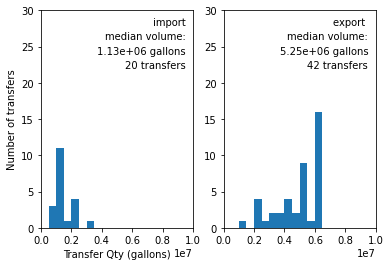

In [71]:
nbins = 20
max_transfer = 1e7 #note: ATB BARGE DBL 185 recorded 1 transfer as 5e7
bin_values = numpy.arange(0,max_transfer,max_transfer/20)
export_qty = {}
import_qty={}
for dawg in top_dawgs:
    print(dawg)
    export_qty[dawg]=exports.loc[
            exports.Receiver == dawg,
            ['TransferQtyInGallon','AntID']
        ].groupby('AntID').sum()
    import_qty[dawg]=imports.loc[
            imports.Deliverer == dawg,
            ['TransferQtyInGallon','AntID']
        ].groupby('AntID').sum()
    fig, ax = plt.subplots(1,2)
    # the histogram of the data
    n, bins, patches = ax[0].hist(import_qty[dawg],bins = bin_values)
    n, bins, patches = ax[1].hist(export_qty[dawg],bins = bin_values)
    ax[0].set_xlabel('Transfer Qty (gallons)')
    ax[0].set_ylabel('Number of transfers')
    # add useful information
    ax[0].text(max_transfer-.5e6,28,'import', horizontalalignment='right')
    ax[0].text(max_transfer-.5e6,26,'median volume:', horizontalalignment='right')
    ax[0].text(max_transfer-.5e6,24,f'{numpy.median(import_qty[dawg]):.2e} gallons', horizontalalignment='right')
    ax[0].text(max_transfer-.5e6,22,f'{len(import_qty[dawg])} transfers', horizontalalignment='right')
    
    ax[1].text(max_transfer-.5e6,28,'export ', horizontalalignment='right')
    ax[1].text(max_transfer-.5e6,26,'median volume:', horizontalalignment='right')
    ax[1].text(max_transfer-.5e6,24,f'{numpy.median(export_qty[dawg]):.2e} gallons', horizontalalignment='right')
    ax[1].text(max_transfer-.5e6,22,f'{len(export_qty[dawg])} transfers', horizontalalignment='right')
    # ax[0].set_title(f'{dawg} (median in:{numpy.median(import_qty[dawg])}, median out:{numpy.median(export_qty[dawg])})')
    for numax in [0,1]:
        ax[numax].set_ylim(0,30)
        ax[numax].set_xlim(0,max_transfer)
    plt.show()
    

In [26]:
atb_df['MMSI'].head()

,DELIVERER,Cargo Capacity
0,ATB BARGE 550-2,6510000
1,ATB BARGE 550-3,6510000
2,ITB ISLAND TRADER,NaN
3,ATB BARGE KIRBY 185-01,7770000
4,ATB BARGE 650-7,7476000


In [27]:
export_df = pandas.merge(
    left = export_df,
    right = atb_df['MMSI'],
    how='left',
    left_on = 'Receiver',
    right_on = 'DELIVERER'
)
import_df = pandas.merge(
    left = import_df,
    right = atb_df['MMSI'],
    how='left',
    left_on = 'Deliverer',
    right_on = 'DELIVERER'
)

In [28]:
export_df['PercentFull']=export_df['AverageQty']/export_df['Cargo Capacity']
import_df['PercentFull']=import_df['AverageQty']/import_df['Cargo Capacity']

In [29]:
export_df

,Count,TransferQtyInGallon,AverageQty,DELIVERER,Cargo Capacity,PercentFull
0,42,206270400.0,4.911200e+06,ATB BARGE 550-2,6510000,0.754409
1,6,27510000.0,4.585000e+06,ATB BARGE 550-3,6510000,0.704301
2,32,120372000.0,3.761625e+06,ATB BARGE 650-10,7476000,0.50316
3,4,22050000.0,5.512500e+06,ATB BARGE 650-2,7476000,0.73736
4,6,34860000.0,5.810000e+06,ATB BARGE 650-7,7476000,0.777154
5,30,63378000.0,2.112600e+06,ATB BARGE ALL ABOARD FOR A CURE,NaN,NaN
6,43,324366000.0,7.543395e+06,ATB BARGE DBL 185,6300000,1.197364
7,1,3108000.0,3.108000e+06,ATB BARGE DBL 78,NaN,NaN
8,1,7560000.0,7.560000e+06,NaN,NaN,NaN
9,5,16380000.0,3.276000e+06,ATB BARGE DR. ROBERT J. BEALL,3360000,0.975


In [30]:
import_df

,Count,TransferQtyInGallon,AverageQty,DELIVERER,Cargo Capacity,PercentFull
0,20,28308000.0,1.415400e+06,ATB BARGE 550-2,6510000,0.217419
1,4,12390000.0,3.097500e+06,ATB BARGE 550-3,6510000,0.475806
2,14,28857150.0,2.061225e+06,ATB BARGE 650-10,7476000,0.275712
3,1,2100000.0,2.100000e+06,ATB BARGE 650-2,7476000,0.280899
4,2,2520000.0,1.260000e+06,ATB BARGE 650-7,7476000,0.168539
5,40,60984000.0,1.524600e+06,ATB BARGE ALL ABOARD FOR A CURE,NaN,NaN
6,29,23860410.0,8.227728e+05,ATB BARGE DBL 185,6300000,0.130599
7,2,3360000.0,1.680000e+06,ATB BARGE DR. ROBERT J. BEALL,3360000,0.5
8,11,20384000.0,1.853091e+06,ATB BARGE FIGHT FANCONI ANEMIA,NaN,NaN
9,5,20137110.0,4.027422e+06,ATB BARGE KIRBY 185-01,7770000,0.51833


In [31]:
fill_out = numpy.nanmedian(export_df['PercentFull'].tolist())
fill_in = numpy.nanmedian(import_df['PercentFull'].tolist())

net_in = numpy.sum(import_df['TransferQtyInGallon'])
net_out = numpy.sum(export_df['TransferQtyInGallon'])
net_transferred = (net_in + net_out)

print(f'Export fill percentage: {fill_out:.3f}')
print(f'Number of export transfers {sum(export_df["Count"])}')

print(f'Import fill percentage: {fill_in:.3f}')
print(f'Number of import transfers {sum(import_df["Count"])}')

print(f'full/empty ratio ((import transfers) / (export transfers)): {sum(import_df["Count"])/sum(export_df["Count"]):.3f}')
print(f'full/empty ratio (weighted fill percentage): {fill_out*net_out/net_transferred+fill_in*net_in/net_transferred:.3f}')

Export fill percentage: 0.746
Number of export transfers 297
Import fill percentage: 0.278
Number of import transfers 185
full/empty ratio ((import transfers) / (export transfers)): 0.623
full/empty ratio (weighted fill percentage): 0.647


###  Identify marine terminal with greatest number of ATB and barge transfers
(TBD: Haven't yet started this analysis)
- What is the behavior at this marine terminal?
- How many vessels both deliver and receive to this terminal?
- How many just deliver?
- How many just receive?

### Identify an ATBs that deliver and receive from same terminal 

###  ATBs that both deliver and receive: 
- `ATB BARGE DBL 185` (32/43)
- `ATB BARGE ONEDREAM` (23/39)
- `ATB BARGE ALL ABOARD FOR A CURE` (40/30)

In [32]:
print(32/43)
print(23/39)
print(30/40)

0.7441860465116279
0.5897435897435898
0.75
